# DataFlowTasks.jl


`DataFlowTasks.jl` is a Julia package dedicated to parallel programming on multi-core shared memory CPUs. From user annotations (READ, WRITE, READWRITE) on program data, `DataFlowTasks.jl` automatically infers dependencies between parallel tasks.

## Installation

```julia
using Pkg
Pkd.add("https://github.com/maltezfaria/DataFlowTasks.jl.git")
```

## Basic Usage

`DataFlowTasks.jl` allows decomposing a program into tasks, that are meant to be used in a very similar way to Julia native `Task`s. The API implements three macros :

- `@dspawn`
- `@dtask`
- `@dasync`

which behave like their `Base` counterparts, except they take additional annotations that declare how each task affects the data it accesses:

- read-only: `@R` or `@READ`
- write-only: `@W` or `@WRITE`
- read-write: `@RW` or `@READWRITE`

Anywhere in the task body, a `@R(A)` annotation for example implies that `A` will be accessed in read-only mode by the task.

Let's look at a simple example:

In [1]:
using DataFlowTasks
DataFlowTasks.reset!() #hide
A = Vector{Float64}(undef, 4)
result = let
    @dspawn fill!(@W(A), 0)           # task 1: accesses everything
    @dspawn @RW(view(A, 1:2)) .+= 2   # task 2: modifies the first half
    @dspawn @RW(view(A, 3:4)) .+= 3   # task 3: modifies the second half
    @dspawn @R(A)                     # task 4: get the result
end
fetch(result)

4-element Vector{Float64}:
 2.0
 2.0
 3.0
 3.0

From annotations describing task-data dependencies, `DataFlowTasks.jl` infers dependencies between tasks. Internally, this set of dependencies is represented as a Directed Acyclic Graph (DAG):

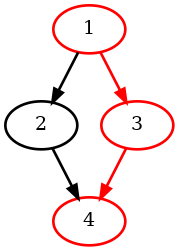

In [2]:
using GraphViz
DataFlowTasks.dagplot()

In the example above, tasks 2 & 3 access different parts of array `A` and are therefore independant, as shown in the DAG.

## Example : Parallel Cholesky Factorization

As a less contrived example, we illustrate below the use of `DataFlowTasks` to parallelize a tiled Cholesky factorization. The implementation shown here is delibarately made as simple as possible; a more complex and more efficient implementation can be found in the [TiledFactorization](https://github.com/maltezfaria/TiledFactorization) package.

The Cholesky factorization algorithm takes a symmetric positive definite matrix A and finds a lower triangular matrix L such that `A = LLᵀ`. The tiled version of this algorithm decomposes the matrix A into tiles (of even sizes, in this simplified version). At each step of the algorithm, we do a Cholesky factorization on the diagonal tile, use a triangular solve to update all of the tiles at the right of the diagonal tile, and finally update all the tiles of the submatrix with a schur complement.

If we have a matrix A decomposed in `n x n` tiles, then the algorithm will have `n` steps. The `i`-th step (with `i ∈ [1:n]`) will perform

- `1` cholesky factorization of the (i,i) block,
- `(i-1)` triangular solves (one for each block in the `i`-th row),
- `i*(i-1)/2` matrix multiplications to update the submatrix.

The following image illustrates the 2nd step of the algorithm:

![](Cholesky_2ndStep.png)

A sequential tiled factorization algorithm can be implemented as:

In [3]:
using LinearAlgebra

tilerange(ti, ts) = (ti-1)*ts+1:ti*ts

function cholesky_tiled!(A, ts)
    m = size(A, 1); @assert m==size(A, 2)
    m%ts != 0 && error("Tilesize doesn't fit the matrix")
    n = m÷ts  # number of tiles in each dimension

    T = [view(A, tilerange(i, ts), tilerange(j, ts)) for i in 1:n, j in 1:n]

    for i in 1:n
        # Diagonal cholesky serial factorization
        cholesky!(T[i,i])

        # Left blocks update
        U = UpperTriangular(T[i,i])
        for j in i+1:n
            ldiv!(U', T[i,j])
        end

        # Submatrix update
        for j in i+1:n
            for k in j:n
                mul!(T[j,k], T[i,j]', T[i,k], -1, 1)
            end
        end
    end

    # Construct the factorized object
    return Cholesky(A, 'U', zero(LinearAlgebra.BlasInt))
end

cholesky_tiled! (generic function with 1 method)

Parallelizing the code with `DataFlowTasks.jl` is as easy as wrapping function calls within `@dspawn`, and adding annotations describing data access modes:

In [4]:
using DataFlowTasks

function cholesky_dft!(A, ts)
    m = size(A, 1); @assert m==size(A, 2)
    m%ts != 0 && error("Tilesize doesn't fit the matrix")
    n = m÷ts  # number of tiles in each dimension

    T = [view(A, tilerange(i, ts), tilerange(j, ts)) for i in 1:n, j in 1:n]

    for i in 1:n
        # Diagonal cholesky serial factorization
        @dspawn cholesky!(@RW(T[i,i])) label="chol ($i,$i)"

        # Left blocks update
        U = UpperTriangular(T[i,i])
        for j in i+1:n
            @dspawn ldiv!(@R(U)', @RW(T[i,j])) label="ldiv ($i,$j)"
        end

        # Submatrix update
        for j in i+1:n
            for k in j:n
                @dspawn mul!(@RW(T[j,k]), @R(T[i,j])', @R(T[i,k]), -1, 1) label="schur ($j,$k)"
            end
        end
    end

    # Construct the factorized object
    r = @dspawn Cholesky(@R(A), 'U', zero(LinearAlgebra.BlasInt)) label="result"
    return fetch(r)
end

cholesky_dft! (generic function with 1 method)

(Also note how extra annotations were added in the code, in order to attach meaningful labels to the tasks. These will later be useful to interpret the output of debugging & profiling tools.)

The code below shows how to use this `cholesky_tiled!` function, as well as how to profile the program and get information about how tasks were scheduled:

In [5]:
# DataFlowTasks environnement setup
DataFlowTasks.reset!()
DataFlowTasks.enable_log()

# Context
n  = 2048
ts = 512
A = rand(n, n)
A = (A + adjoint(A))/2
A = A + n*I;

In [6]:
@info "Testing sequential Cholesky factorization"          #hide
F = cholesky_tiled!(copy(A), ts)                           #hide
                                                           #hide
# Check results                                           #hide
err = norm(F.L*F.U-A,Inf)/max(norm(A),norm(F.L*F.U))       #hide
@show err                                                  #hide
@assert err < eps(Float64)                                 #hide

[ Info: Testing sequential Cholesky factorization
err = 9.810045277320037e-18


In [7]:
@info "Testing parallel Cholesky factorization" #hide

# First run to trigger compilation
F = cholesky_dft!(copy(A), ts)

# Check results
err = norm(F.L*F.U-A,Inf)/max(norm(A),norm(F.L*F.U))
@show err                   #hide
@assert err < eps(Float64)  #hide

[ Info: Testing parallel Cholesky factorization
err = 9.810045277320037e-18


## Debugging and Profiling

DataFlowTasks comes with debugging and profiling tools which help understanding how task dependencies were inferred, and how tasks were scheduled during execution.

As usual when profiling code, it is recommended to start from a state where all code has already been compiled, and all previous profiling information has been discarded:

In [8]:
# Reset profiling environnement
DataFlowTasks.resetlogger!()
GC.gc()

# Real workload to be analysed
cholesky_dft!(A ,ts);

Visualizing the DAG can be helpful. When debugging, this representation of dependencies between tasks as inferred by `DataFlowTasks` can help identify missing or erroneous data dependency annotations. When profiling, identifying the critical path (plotted in red in the DAG) can help understand the performances of the implementation.

In the real-world example of the tiled Cholesky factorization, we can see how quickly the DAG complexity increases (even though the test case only has 4x4 blocks here):

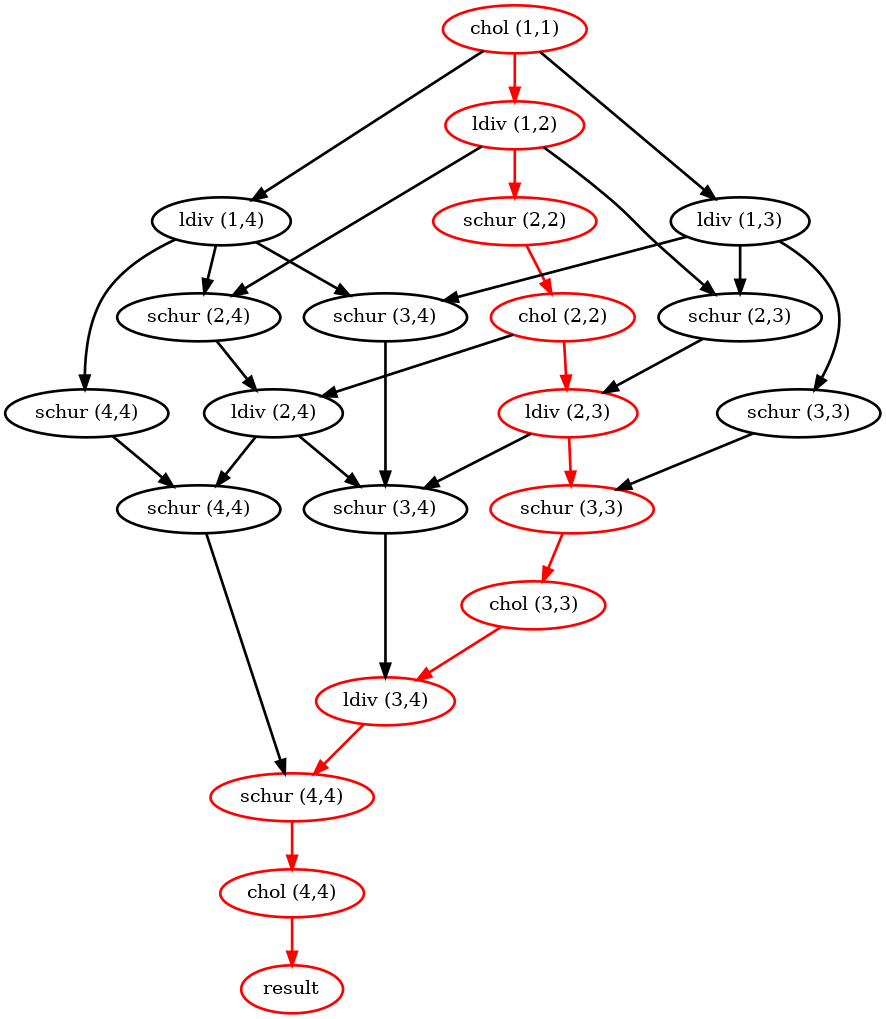

In [9]:
using GraphViz
dag = DataFlowTasks.dagplot()

The parallel trace plot shows a timeline of the tasks execution on available threads. It helps understanding how tasks were scheduled. The same window also carries other general information allowing to better understand the performance limiting factors:

[ Info: Computing    : 0.13818910900000006
[ Info: Inserting    : 4.324000000000001e-5
[ Info: Other        : 0.08672169099346298


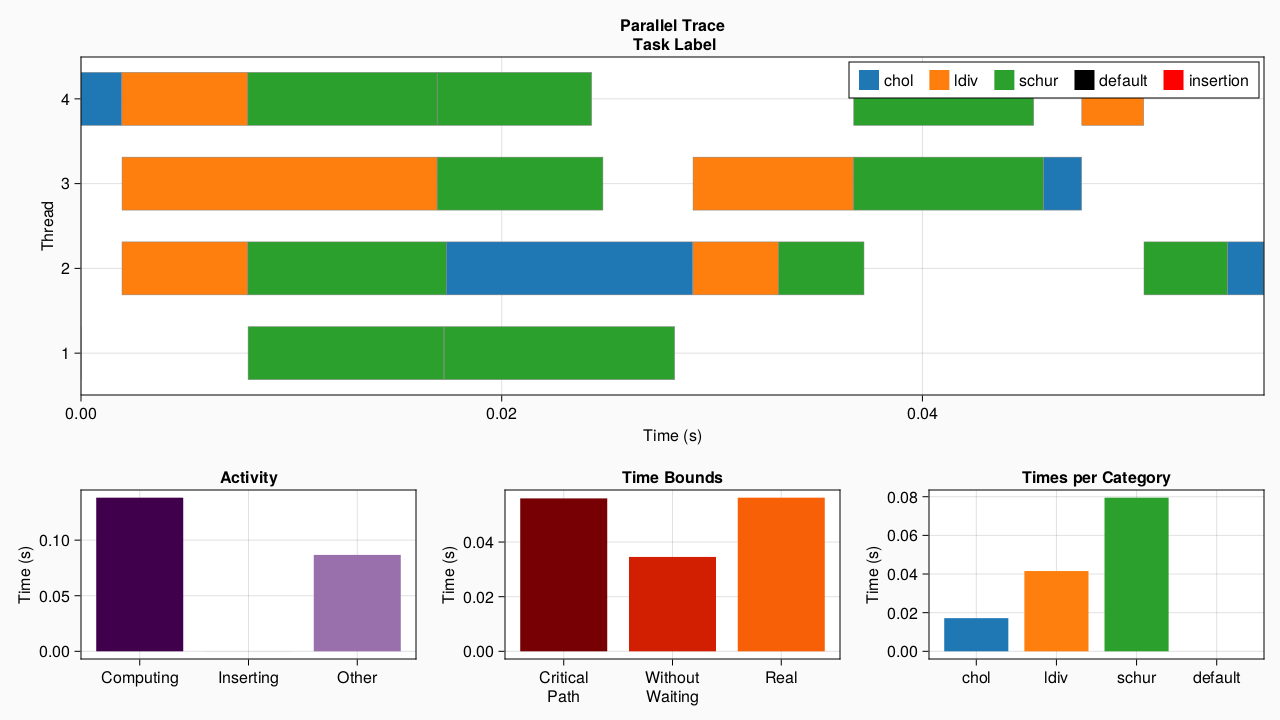

In [10]:
using CairoMakie # or GLMakie in order to have more interactivity
trace = DataFlowTasks.plot(categories=["chol", "ldiv", "schur"])

We see here that the execution time is bounded by the length of the critical path: with this block size and matrix size, the algorithm does not expose enough parallelism to occupy all threads without waiting periods.

We'll cover in details the usage and possibilities of the visualization in the documentation.

Note that the debugging & profiling tools need additional dependencies such as `Makie` and `GraphViz`, which are only meant to be used interactively during the development process. These packages are therefore only considered as optional depdendencies, and it is up the the user to set the environment in such a way that they are available.

# Performances

The performance of this example can be improved by using better implementations for the sequential building blocks operating on tiles:

- `LoopVectorization.jl` can improve the performance of the sequential cholesky factorization of diagonal blocks
- `TriangularSolve.jl` provides a high-performance `ldiv!` implementation
- `Octavian.jl` provides fast, pure-Julia matmuls for the Schur complements.

This approach is taken in [`TiledFactorization.jl`](https://github.com/maltezfaria/TiledFactorization), where all the above mentioned building blocks are combined with the parallelization strategy presented here. The performances of this implementation is assessed in the following plot, by comparison to MKL on a the case of a 5000x5000 matrix decomposed in tiles of size 256x256.

![](scalability_lfaria.png)

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*